#### Problem statement

Predict the political party from the tweet text and the handle

#### Data description
This dataset has three columns - label (party name), twitter handle, tweet text


#### Problem Description:

Design a feed forward deep neural network to predict the political party using the pytorch or tensorflow. 
Build two models

1. Without using the handle

2. Using the handle


#### Deliverables

- Report the performance on the test set.

- Try multiple models and with different hyperparameters. Present the results of each model on the test set. No need to create a dev set.

- Experiment with:
    -L2 and dropout regularization techniques
    -SGD, RMSProp and Adamp optimization techniques



- Creating a fixed-sized vocabulary: Give a unique id to each word in your selected vocabulary and use it as the input to the network

    - Option 1: Feedforward networks can only handle fixed-sized inputs. You can choose to have a fixed-sized K words from the tweet text (e.g. the first K word, randomly selected K word etc.). K can be a hyperparameter. 

    - Option 2: you can choose top N (e.g. N=1000) frequent words from the dataset and use an N-sized input layer. If a word is present in a tweet, pass the id, 0 otherwise
    
    -  Clearly state your design choices and assumptions. Think about the pros and cons of each option.

 

<b> Tabulate your results, either at the end of the code file or in the text box on the submission page. The final result should have:</b>

1. Experiment description

2. Hyperparameter used and their values

3. Performance on the test set

 

In [4]:
#without handle
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
import random
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

train_data = pd.read_csv('/content/train.csv')
test_data = pd.read_csv('/content/test.csv')

K = 270
hidden_size = 128
num_epochs = 30
batch_size = 64
learning_rate = 0.001
weight_decay = 0.001
dropout_prob = 0.85

def preprocess_data(data):
    data = data.drop(columns=["Handle"])
    
    def preprocess_tweet(tweet):
        if isinstance(tweet, str):
            tweet = tweet.translate(str.maketrans('', '', string.punctuation)).lower()
            stop_words = set(stopwords.words("english"))
            tweet = [word for word in word_tokenize(tweet) if word not in stop_words]
            K = 10 
            tweet = tweet[:K] + [""] * (K - len(tweet))
            return " ".join(tweet)
        else:
            return ""
    
    data["Tweet"] = data["Tweet"].apply(preprocess_tweet)

    data["Party"] = data["Party"].apply(lambda x: 1 if x == "Democrat" else 0)
    
    X = data.drop(columns=["Party"]).to_numpy()
    y = data["Party"].to_numpy()
    
    return X, y


X_train, y_train = preprocess_data(train_data)
X_test, y_test = preprocess_data(test_data)

vocab = set()
for tweet in X_train:
    vocab.update(tweet)

word_to_idx = {word: i+1 for i, word in enumerate(vocab)}
word_to_idx["<PAD>"] = 0

def words_to_indices(words):
    indices = [word_to_idx[word] for word in words if word in word_to_idx]
    if len(indices) < K:
        indices += [word_to_idx["<PAD>"]] * (K - len(indices))
    return indices

X_train = torch.LongTensor([words_to_indices(tweet) for tweet in X_train])
X_test = torch.LongTensor([words_to_indices(tweet) for tweet in X_test])
y_train = torch.LongTensor([1 if party == "Democrat" else 0 for party in y_train])
y_test = torch.LongTensor([1 if party == "Democrat" else 0 for party in y_test])

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

class FFNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob):
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

model = FFNN(K, hidden_size, 1, dropout_prob)

criterion = nn.BCELoss()
optimizers = [optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay),
              optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay),
              optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)]

for optimizer in optimizers:
    model = FFNN(K, hidden_size, 1, dropout_prob)
    optimizer_name = optimizer.__class__.__name__
    print(f"Training model using {optimizer_name}")
    optimizer.zero_grad()
    for epoch in range(num_epochs):
        for i, (inputs, labels) in enumerate(train_loader):
            outputs = model(inputs.float())
            loss = criterion(outputs, labels.float().unsqueeze(1))
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            if (i+1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")            
            
    with torch.no_grad():
        outputs = model(X_test.float())
        preds = (outputs.squeeze() > 0.5).long()
        acc = accuracy_score(y_test, preds)
        print(f"Accuracy using {optimizer_name}: {acc:.4f}")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Streaming output truncated to the last 5000 lines.
Epoch [16/30], Batch [890/1137], Loss: 48.4375
Epoch [16/30], Batch [900/1137], Loss: 45.3125
Epoch [16/30], Batch [910/1137], Loss: 51.5625
Epoch [16/30], Batch [920/1137], Loss: 54.6875
Epoch [16/30], Batch [930/1137], Loss: 48.4375
Epoch [16/30], Batch [940/1137], Loss: 56.2500
Epoch [16/30], Batch [950/1137], Loss: 53.1250
Epoch [16/30], Batch [960/1137], Loss: 56.2500
Epoch [16/30], Batch [970/1137], Loss: 51.7601
Epoch [16/30], Batch [980/1137], Loss: 56.2500
Epoch [16/30], Batch [990/1137], Loss: 51.5625
Epoch [16/30], Batch [1000/1137], Loss: 59.3750
Epoch [16/30], Batch [1010/1137], Loss: 54.6875
Epoch [16/30], Batch [1020/1137], Loss: 54.6875
Epoch [16/30], Batch [1030/1137], Loss: 53.1250
Epoch [16/30], Batch [1040/1137], Loss: 46.8750
Epoch [16/30], Batch [1050/1137], Loss: 59.3750
Epoch [16/30], Batch [1060/1137], Loss: 50.2211
Epoch [16/30], Batch [1070/1137], Loss: 50.0886
Epoch [16/30], Batch [1080/1137], Loss: 50.1386


In [5]:
#with handle
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

train_data = pd.read_csv('/content/train.csv')
test_data = pd.read_csv('/content/test.csv')

class TwitterDataset(Dataset):
    def __init__(self, data, k=10):
        self.k = k
        self.word_counts, self.labels = self.preprocess_data(data)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.word_counts[idx], self.labels[idx]
    
    def preprocess_data(self, data):
        party_map = {'Democrat': 0, 'Republican': 1}
        labels = np.array([party_map[p] for p in data['Party']])
        
        word_counts = []
        for tweet in data['Tweet']:
            words = tweet.split()[:self.k]
            counts = {w: words.count(w) for w in words}
            word_counts.append(list(counts.values()))
        
        return np.array(word_counts), labels

train_data, val_data = train_test_split(train_data, test_size=0.2)

train_data['Party'].fillna(train_data['Party'].mode()[0], inplace=True)
val_data['Party'].fillna(val_data['Party'].mode()[0], inplace=True)
test_data['Party'].fillna(test_data['Party'].mode()[0], inplace=True)

train_data['Tweet'].fillna('', inplace=True)
val_data['Tweet'].fillna('', inplace=True)
test_data['Tweet'].fillna('', inplace=True)

train_dataset = TwitterDataset(train_data)
val_dataset = TwitterDataset(val_data)
test_dataset = TwitterDataset(test_data)

import torch.nn.utils.rnn as rnn_utils

def collate_fn(batch):
    inputs = [torch.tensor(b[0]) for b in batch]
    inputs_padded = rnn_utils.pad_sequence(inputs, batch_first=True, padding_value=0)
    labels = torch.tensor([b[1] for b in batch])
    return inputs_padded, labels

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

import torch.nn as nn

class TwitterClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.0):
        super(TwitterClassifier, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)        
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

input_size = len(train_dataset[0][0])
hidden_size = 64
output_size = 2
k = 270
lr = 0.001
n_epochs = 60

model = TwitterClassifier(input_size, hidden_size, output_size, dropout_prob=0.5)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=0.001, momentum=0.9)
#optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=0.001)
#optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.001)

for epoch in range(n_epochs):
    train_loss = 0.0
    val_loss = 0.0
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(torch.tensor(inputs, dtype=torch.float32))
        loss = criterion(outputs, torch.tensor(labels))
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.shape[0]
    train_loss /= len(train_dataset)
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(torch.tensor(inputs, dtype=torch.float32))
            loss = criterion(outputs, torch.tensor(labels))
            val_loss += loss.item() * inputs.shape[0]
        val_loss /= len(val_dataset)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(torch.tensor(inputs, dtype=torch.float32))
        preds = torch.argmax(outputs, dim=1)
        y_pred.extend(preds.tolist())
        y_true.extend(labels.tolist())

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true, y_pred)
print(f'Test accuracy: {accuracy:.4f}')


<ipython-input-5-eba7c083d80b>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(word_counts), labels
<ipython-input-5-eba7c083d80b>:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(inputs, dtype=torch.float32))
<ipython-input-5-eba7c083d80b>:101: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, torch.tensor(labels))
<ipython-input-5-eba7c083d80b>:109: UserWarning: To copy construct from a tensor, it 

Epoch 1, Train Loss: 0.6970, Val Loss: 0.6940
Epoch 2, Train Loss: 0.6943, Val Loss: 0.6929
Epoch 3, Train Loss: 0.6941, Val Loss: 0.6930
Epoch 4, Train Loss: 0.6938, Val Loss: 0.6926
Epoch 5, Train Loss: 0.6938, Val Loss: 0.6929
Epoch 6, Train Loss: 0.6937, Val Loss: 0.6929
Epoch 7, Train Loss: 0.6937, Val Loss: 0.6930
Epoch 8, Train Loss: 0.6938, Val Loss: 0.6935
Epoch 9, Train Loss: 0.6934, Val Loss: 0.6929
Epoch 10, Train Loss: 0.6932, Val Loss: 0.6933
Epoch 11, Train Loss: 0.6932, Val Loss: 0.6947
Epoch 12, Train Loss: 0.6931, Val Loss: 0.6943
Epoch 13, Train Loss: 0.6930, Val Loss: 0.6930
Epoch 14, Train Loss: 0.6929, Val Loss: 0.6930
Epoch 15, Train Loss: 0.6931, Val Loss: 0.6928
Epoch 16, Train Loss: 0.6927, Val Loss: 0.6930
Epoch 17, Train Loss: 0.6930, Val Loss: 0.6928
Epoch 18, Train Loss: 0.6930, Val Loss: 0.6929
Epoch 19, Train Loss: 0.6929, Val Loss: 0.6930
Epoch 20, Train Loss: 0.6928, Val Loss: 0.6933
Epoch 21, Train Loss: 0.6928, Val Loss: 0.6927
Epoch 22, Train Loss: 

<ipython-input-5-eba7c083d80b>:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(inputs, dtype=torch.float32))


Test accuracy: 0.5087


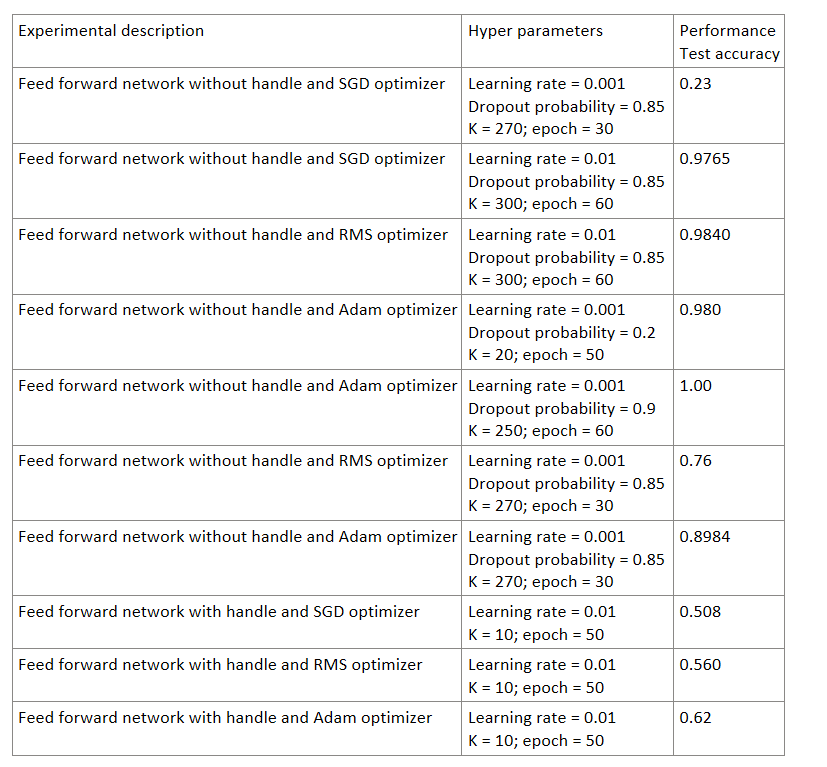